In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys
import json
import importlib
from copy import deepcopy

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error as mse

from tqdm.notebook import tqdm
from numba import njit
sys.path.append('./ableen_module')
sys.path.append('./data')
# from ableen_module import data_handler as dh
from ableen_module import backtests as bt
from ableen_module import tools, gym, drawers

sns.set_theme(style='darkgrid')
sns.color_palette('rainbow')
plt.figure(figsize=(24, 12))

<Figure size 2400x1200 with 0 Axes>

<Figure size 2400x1200 with 0 Axes>

In [3]:
def get_mid_prices(coin):
    data = pd.read_csv('data/'+coin+'.csv')
    mid_prices = data['midpoint'][:17100]
    return mid_prices/np.mean(mid_prices)

In [4]:
session_lenght = 17100
timestamps = np.arange(session_lenght)
assets = ['hsecoin', 'pypycoin', 'weirdocoin', 'lolcoin', 'rucoin', 'easycoin']
eth = get_mid_prices('ETH')
btc = get_mid_prices('BTC')
ada = get_mid_prices('ADA')

hsecoin = btc*0.5+eth*0.2-ada*0.4
pypycoin = btc*0.3-eth*0.2+ada*0.5
weirdocoin = hsecoin*3-pypycoin-btc*0.5
lolcoin = pypycoin*1.4+btc*0.3-eth*0.1-ada*0.07+hsecoin-pypycoin*0.2
rucoin = lolcoin*0.5+pypycoin*0.6 + eth*0.1 + btc*0.15+weirdocoin*0.3
easycoin = lolcoin*3-rucoin+pypycoin/2

data_dict = dict()
data_dict['server_ts'] = timestamps
data_dict['hsecoin'] = hsecoin
data_dict['rucoin'] = rucoin
data_dict['easycoin'] = easycoin
data_dict['lolcoin'] = lolcoin
data_dict['pypycoin'] = pypycoin
data_dict['weirdocoin'] = weirdocoin

data = pd.DataFrame(data_dict).set_index('server_ts')
data

,hsecoin,rucoin,easycoin,lolcoin,pypycoin,weirdocoin
server_ts,,,,,,
0,0.289052,1.048071,2.441568,1.072398,0.544889,-0.143719
1,0.288020,1.048649,2.446170,1.073761,0.547072,-0.149434
2,0.286877,1.049461,2.451462,1.075368,0.549639,-0.155974
3,0.288270,1.048023,2.443092,1.072696,0.546057,-0.147293
4,0.286349,1.047327,2.446451,1.073186,0.548440,-0.155410
...,...,...,...,...,...,...
17095,0.290977,1.078143,2.474951,1.089687,0.568067,-0.171508
17096,0.290855,1.078611,2.477640,1.090625,0.568751,-0.172871
17097,0.289512,1.077487,2.478172,1.090251,0.569813,-0.177641


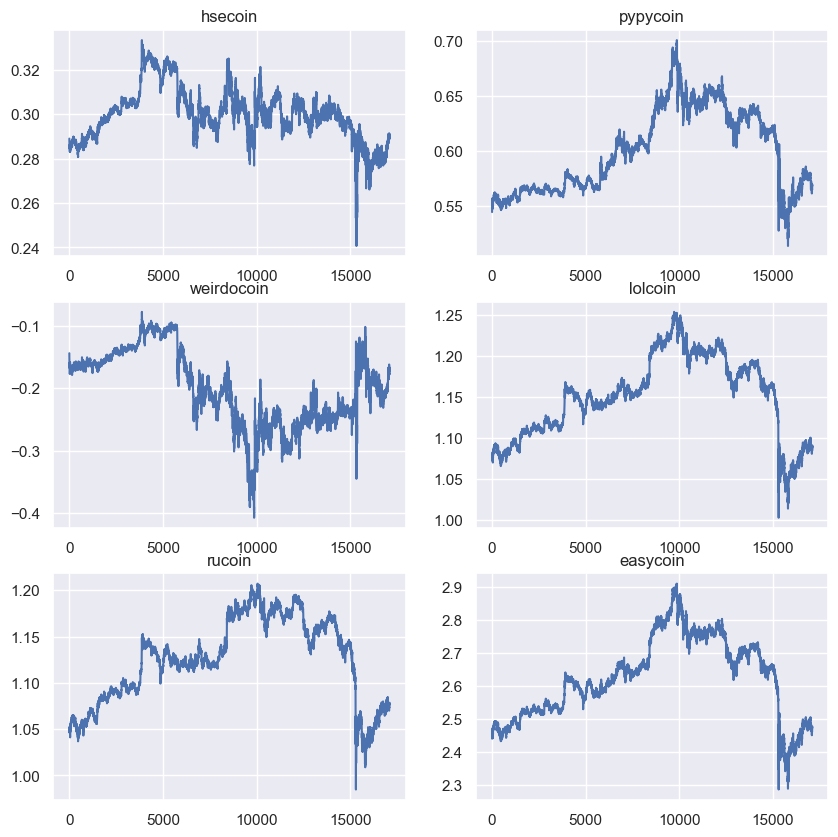

In [5]:
plt.figure(figsize=(10, 10))

for indx, inst in enumerate(assets):
    plt.subplot(3, 2, indx + 1)
    plt.plot(data[inst])
    plt.title(inst)
    
plt.show()

In [6]:
def my_ridge(X_true, y_true, alpha, max_pos_usd):
    '''Single ridge fit.
    Returns weights for non-dependent assets and mean value of linear combination.
    '''
    X_offset = np.average(X_true, axis=0)
    y_offset = np.average(y_true, axis=0)
    X = X_true - X_offset
    y = y_true - y_offset
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    diag = s / (s ** 2 + alpha)
    diag[s < 1e-15] = 0
    d = np.diag(diag)
    coef_ = Vt.T @ d @ U.T @ y
    return coef_

def my_ridge_train(train, alpha=0, dependent_variable=-1, max_position_usd=1000):
    '''Full training pack.
    Returns weights for all assets and mean value of linear combination.
    '''
    nvar = train.shape[1]
    if nvar == 0:
        return np.zeros(0), 0
    dependent_variable %= nvar
    X_assets = np.arange(nvar) != dependent_variable
    X, y = train[:, X_assets], train[:, dependent_variable]
    X_offset = np.average(X, axis=0)
    y_offset = np.average(y, axis=0)
    betas = my_ridge(X, y, alpha, max_position_usd)
    weights = np.zeros(nvar) - 1
    bool_assets = np.where(np.arange(nvar) != dependent_variable)
    weights[bool_assets] = betas
    divider = np.abs(weights).sum()
    weights = np.where(np.abs(weights)*max_position_usd/divider>=10, weights, 0)
    intercept = y_offset - np.dot(X_offset, weights[bool_assets])

    return weights, -intercept

@njit
def linear_comb(assets: np.ndarray, weights: np.ndarray) -> np.ndarray:
    '''Returns linear combination of assets with related weights. 
    '''
    if weights.ndim != 1:
        if weights.shape[0] > assets.shape[0]:
            weights = weights[:assets.shape[0]]
        elif weights.shape[0] < assets.shape[0]:
            assets = assets[:weights.shape[0]]
    result = weights * assets
    return result.sum(axis=1)

In [7]:
# РИДЖ РЕГРЕССИЯ ДОБАВЛЯЕТ К MSE СУММУ КВАДРАТОВ ВЕСОВ ПОМНОЖЕННУЮ НА КОНСТАНТУ, ТАКИМ ОБРАЗОМ, ШТРАФУЯ МОДЕЛЬ ЗА СЛИШКОМ БОЛЬШИЕ ВЕСА МЫ ПОЛУЧАЕМ ПОНИЖЕННОЕ ВЛИЯНИЕ ОТДЕЛЬНЫХ РЯДОВ И СЛЕДОВАТЕЛЬНО ЧУВСТВУЕМ СЕБЯ ЧУТЬ БОЛЕЕ СПОКОЙНЕЕ ВО ВРЕМЕНА СКАЧКОВ ОТДЕЛЬНЫХ АКТИВОВ

In [8]:
alpha = 0.01
train_size = 1200
train_start = 0
train_size -= train_start
assets_data = np.array(data)[train_start:]
train = assets_data[:train_size]
test = assets_data[train_size:]
X = assets_data[:, :-1]
y = assets_data[:, -1]
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

In [9]:
weights, intercept = my_ridge_train(train, alpha=alpha)

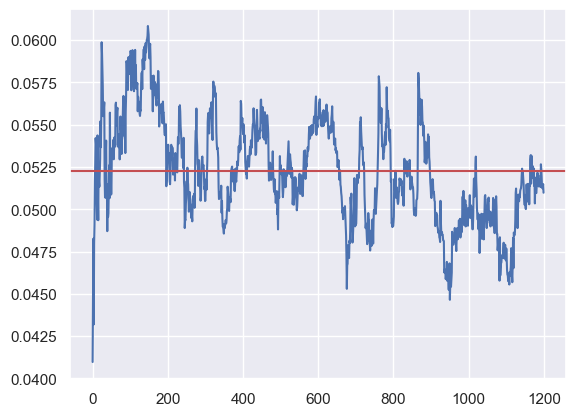

In [10]:
# TRAIN, по умолчанию целевой элемент последний
result_train = linear_comb(assets_data[:train_size], weights)
plt.plot(result_train)
plt.axhline(intercept, color='r')

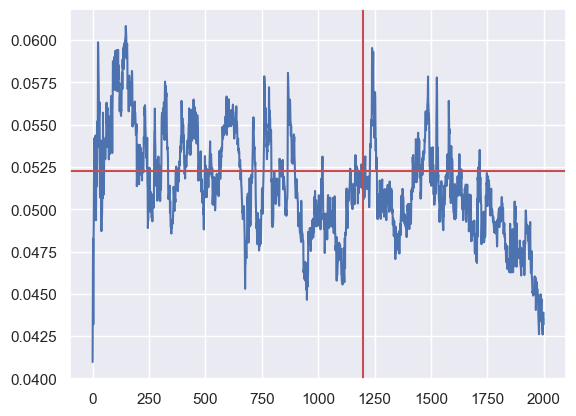

In [11]:
# TRAIN + TEST
result = linear_comb(assets_data[:2000], weights)
plt.plot(result)
plt.axhline(intercept, color='r')
plt.axvline(train_size, color='r')

In [12]:
weights

array([ 0.55841602,  0.48922524, -0.28414457,  0.13957678, -0.42729933,
       -1.        ])

In [13]:
reg = Ridge(alpha=alpha).fit(X_train, y_train)
reg.coef_

array([ 0.55841602,  0.48922524, -0.28414457,  0.13957678, -0.42729933])

In [14]:
# Веса полностью сходятся, подробнее почитать про устройство регрессии можно тут:
# https://talwarabhimanyu.github.io/blog/2020/07/10/svd2

In [15]:
# Коэффициент шарпа - в данном случае прибыль делить на std, можно оптимизировать модель например с помощью optuna и использовать в
# качестве метрики шарп, profit_to_drawdown, или комбинировать метрики и использовать их на разных участках, чтобы потом брать
# среднее или минимальное значение.

In [17]:
# Случайные параметры
mv = drawers.ModelVisualizing(assets_data, assets_data)
mv.set_params(dependent_asset = -1, split_ts=12000, train_size=1200, test_size=500)

<Figure size 2400x1200 with 0 Axes>

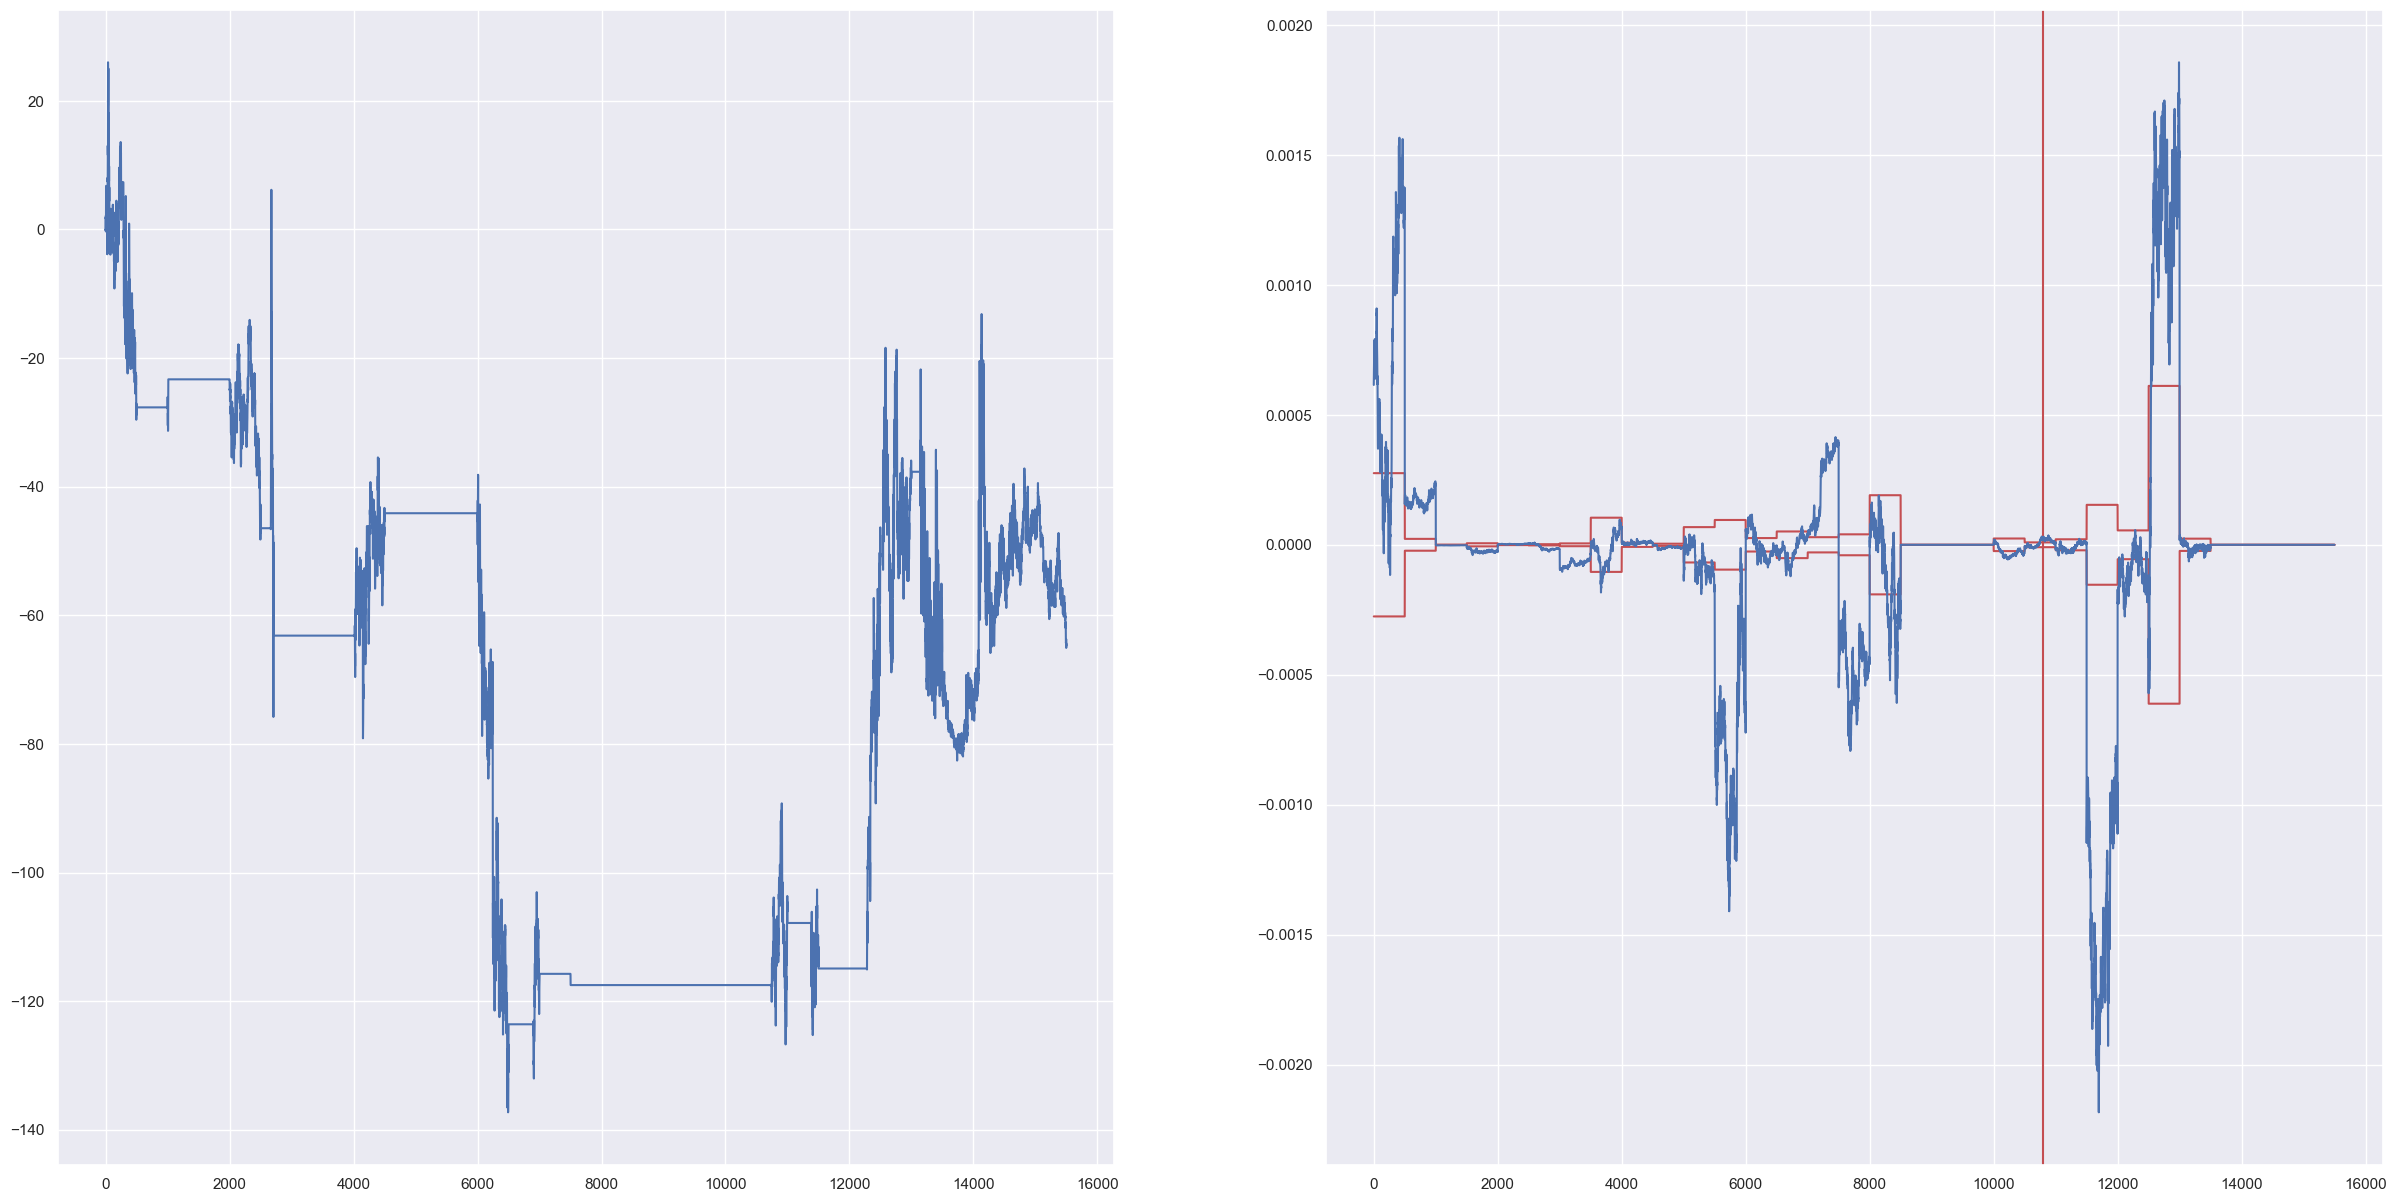

In [18]:
# Слева депозит, справа график изменений линейной комбинации и трешхолдов на всём периоде работы модели
wealthy, count = mv.show_the_case(log=False)